In [1]:
# adapted from https://nn.labml.ai/diffusion/ddpm/index.html and https://learnopencv.com/denoising-diffusion-probabilistic-models/

In [2]:
%load_ext autoreload
%autoreload 2

In [11]:
from datetime import datetime
import gc
import os

import torch
from torch import amp
from torchvision.utils import make_grid
from matplotlib import pyplot as plt

import ddpm

# Overview

![diffusion-models-forwardbackward_process_ddpm.png](diffusion-models-forwardbackward_process_ddpm.png)

The distribution $q$ in the forward diffusion process is defined as Markov Chain given by:

$$
q(x_1, \ldots, x_T | x_0) := \prod_{t=1}^{T} q(x_t | x_{t-1}) \quad \ldots (1)
\\

q(x_t | x_{t-1}) := \mathcal{N}(x_t; \sqrt{1 - \beta_t} x_{t-1}, \beta_t I) \quad \ldots (2)
$$

In practice, rather than sampling increasingly noisy steps, we will use a closed form to get arbitrarily noised samples in one step $q(x_t|x_0)$. With a well-designed variance schedule, we will end up with an approximately normal final noised distribution $q(x_T) \approx \mathcal{N}(0, I)$.

Our task is to learn a model $p_\theta(\mathbf{x_{t-1} | x_t})$ of the reverse diffusion process, where we start with noise from $p(x_T) = \mathcal{N}(0, I)$. Once we can reverse each step, we can integrate over all timesteps to generate a sample $x_0$ from sampled noise $x_T$.

$$
p_\theta(\mathbf{x}_{0:T}) := p(\mathbf{x}_T) \prod_{t=1}^{T} p_\theta(\mathbf{x}_{t-1}|\mathbf{x}_t)
\\
p_\theta(\mathbf{x}_{t-1}|\mathbf{x}_t) := \mathcal{N}(\mathbf{x}_{t-1}; \mu_\theta(\mathbf{x}_t, t), \Sigma_\theta(\mathbf{x}_t, t))

$$

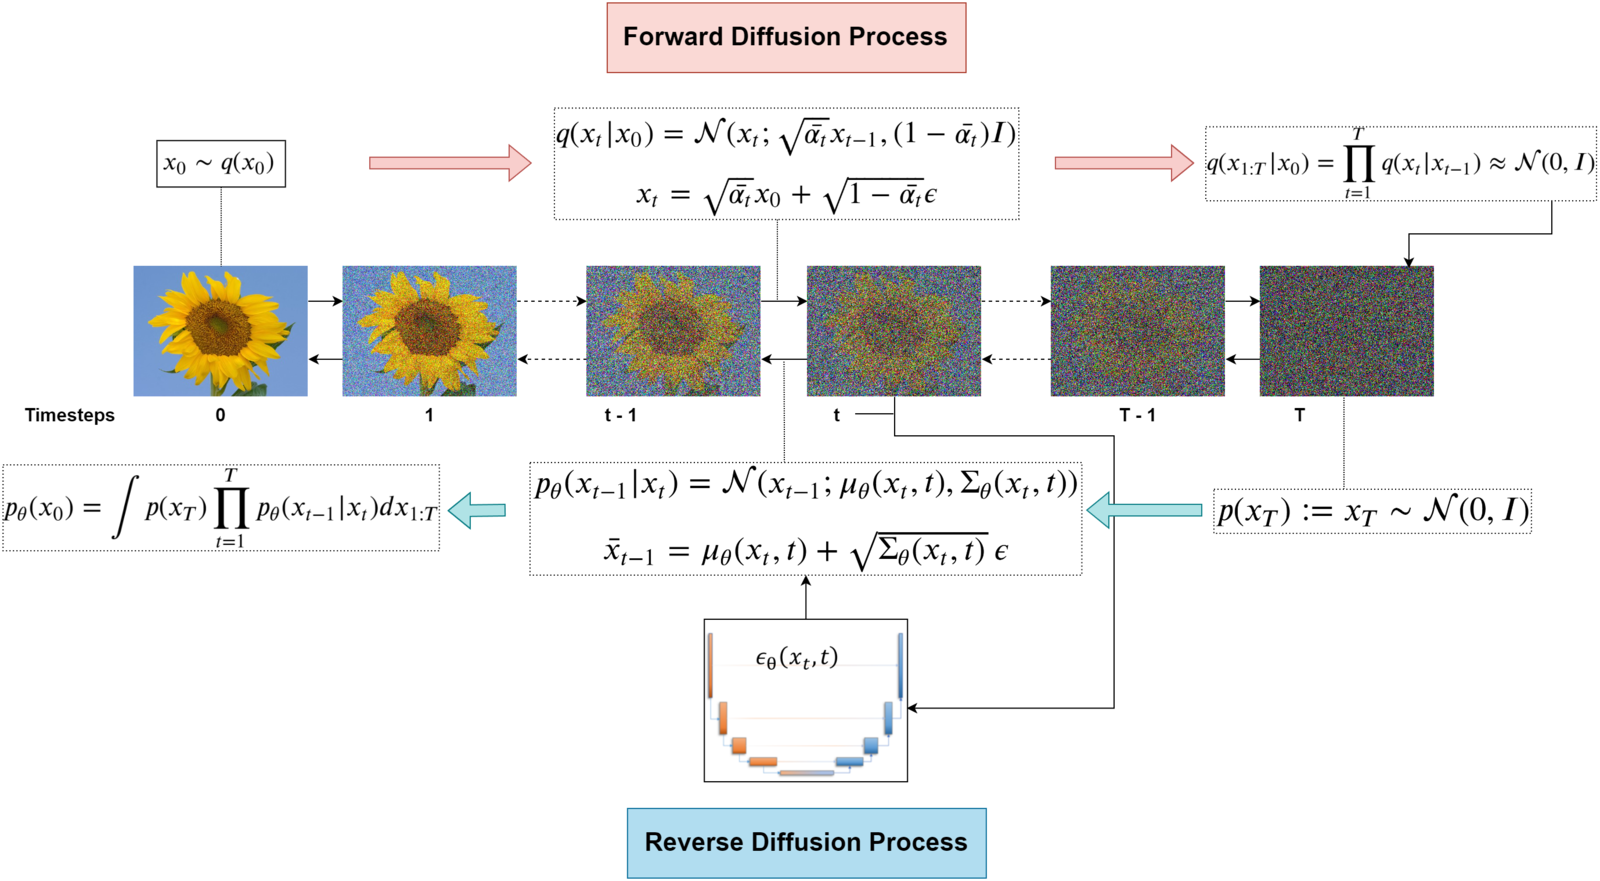

In this tutorial, we will
1. implement the forward process 
    a. designing a noise schedule and,
    b. noising samples from the training data
2. implement the loss and train the model
3. implement the reverse process to sample from the model

# Setup

In [ ]:
from dataclasses import dataclass


@dataclass
class BaseConfig:  # noqa: D101
    DEVICE = ddpm.get_default_device()
    DATASET = "MNIST"  #  "MNIST", "Cifar-10", "Cifar-100", "Flowers"

    # For logging inferece images and saving checkpoints.
    root_log_dir = os.path.join("Logs_Checkpoints", DATASET, "Inference")
    root_checkpoint_dir = os.path.join("Logs_Checkpoints", DATASET, "checkpoints")

    # Current log and checkpoint directory.
    log_dir = "version_0"
    checkpoint_dir = "version_0"


@dataclass
class TrainingConfig:  # noqa: D101
    TIMESTEPS = 1000  # Define number of diffusion timesteps
    IMG_SHAPE = (1, 32, 32) if BaseConfig.DATASET == "MNIST" else (3, 32, 32)
    NUM_EPOCHS = 1
    BATCH_SIZE = 128
    LR = 2e-4
    NUM_WORKERS = 2


@dataclass
class ModelConfig:  # noqa: D101
    BASE_CH = 64  # 64, 128, 256, 512
    BASE_CH_MULT = (1, 2, 4, 8)  # 32, 16, 8, 4
    APPLY_ATTENTION = (False, False, True, False)
    DROPOUT_RATE = 0.1
    TIME_EMB_MULT = 2  # 128

# Exercises

#

The forward process adds noise to the data $x_0 \sim q(x_0)$, for $T$ timesteps.

\begin{align}
q(x_t | x_{t-1}) = \mathcal{N}\big(x_t; \sqrt{1-  \beta_t} x_{t-1}, \beta_t \mathbf{I}\big) \\
q(x_{1:T} | x_0) = \prod_{t = 1}^{T} q(x_t | x_{t-1})
\end{align}

where $\beta_1, \dots, \beta_T$ is the variance schedule.


We can sample $x_t$ at any timestep $t$ with,

\begin{align}
q(x_t|x_0) &= \mathcal{N} \Big(x_t; \sqrt{\bar\alpha_t} x_0, (1-\bar\alpha_t) \mathbf{I} \Big)
\end{align}

where $\alpha_t = 1 - \beta_t$ and $\bar\alpha_t = \prod_{s=1}^t \alpha_s$


## Exercise 1a: implement the noise schedule

First, we compute alpha and beta for all timesteps with the SimpleDiffusion class.

In [5]:
diffusion = ddpm.SimpleDiffusion(
    num_diffusion_timesteps=TrainingConfig.TIMESTEPS,
    img_shape=TrainingConfig.IMG_SHAPE,
    device=BaseConfig.DEVICE,
)

### Plot the noise schedule over diffusion timesteps

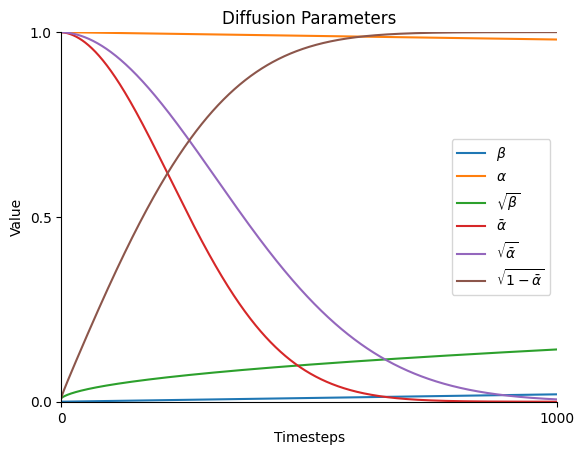

In [6]:
f, ax = plt.subplots()

data = [
    (diffusion.beta, r"$\beta$"),
    (diffusion.alpha, r"$\alpha$"),
    (diffusion.sqrt_beta, r"$\sqrt{\beta}$"),
    (diffusion.alpha_cumulative, r"$\bar{\alpha}$"),
    (diffusion.sqrt_alpha_cumulative, r"$\sqrt{\bar{\alpha}}$"),
    (diffusion.sqrt_one_minus_alpha_cumulative, r"$\sqrt{1 - \bar{\alpha}}$"),
]

for _i, (y, label) in enumerate(data):
    ax.plot(y.cpu().numpy(), label=label)
    ax.set_xlabel("Timesteps")
    ax.set_ylabel("Value")
    ax.legend()
    ax.grid()
    ax.set_ylim(0, 1)
    ax.set_xlim(0, TrainingConfig.TIMESTEPS - 1)
    ax.set_yticks([0, 0.5, 1])
    ax.set_title("Diffusion Parameters")
    ax.set_xticks([0, TrainingConfig.TIMESTEPS])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

## Exercise 1b: sample from the forward process (noise the images)

Once we have the noise schedule implemented in SimpleDiffusion, we can sample $x_t$ at any timestep $t$ with,

\begin{align}
q(x_t|x_0) &= \mathcal{N} \Big(x_t; \sqrt{\bar\alpha_t} x_0, (1-\bar\alpha_t) \mathbf{I} \Big)
\end{align}



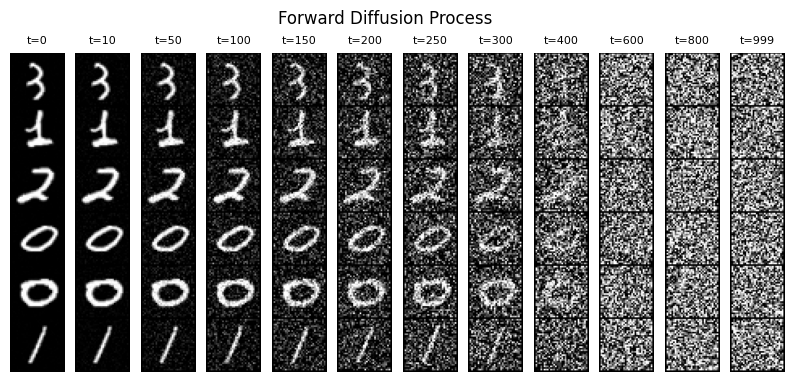

In [7]:
diffusion = ddpm.SimpleDiffusion(num_diffusion_timesteps=TrainingConfig.TIMESTEPS, device="cpu")

loader = iter(
    ddpm.get_dataloader(
        dataset_name=BaseConfig.DATASET,
        batch_size=6,
        device="cpu",
    )
)

x0s, _ = next(loader)

noisy_images = []
specific_timesteps = [0, 10, 50, 100, 150, 200, 250, 300, 400, 600, 800, 999]

for timestep in specific_timesteps:
    timestep = torch.as_tensor(timestep, dtype=torch.long)

    xts, _ = ddpm.forward_diffusion(diffusion, x0s, timestep)
    xts = ddpm.inverse_transform(xts) / 255.0
    xts = make_grid(xts, nrow=1, padding=1)

    noisy_images.append(xts)

# Plot and see samples at different timesteps

_, ax = plt.subplots(1, len(noisy_images), figsize=(10, 5), facecolor="white")

for i, (timestep, noisy_sample) in enumerate(zip(specific_timesteps, noisy_images, strict=False)):
    ax[i].imshow(noisy_sample.squeeze(0).permute(1, 2, 0))
    ax[i].set_title(f"t={timestep}", fontsize=8)
    ax[i].axis("off")
    ax[i].grid(False)

plt.suptitle("Forward Diffusion Process", y=0.9)
plt.axis("off")
plt.show()

## Exercise 2: implement the loss and train

The DDPM loss is based on the evidence lower bound ELBO on the negative log likelihood.

\begin{align}
\mathbb{E}[-\log \textcolor{lightgreen}{p_\theta}(x_0)]
 &\le \mathbb{E}_q [ -\log \frac{\textcolor{lightgreen}{p_\theta}(x_{0:T})}{q(x_{1:T}|x_0)} ] = L \\
\end{align}

However, the authors introduce and use a simplifed loss  


$$L_{\text{simple}}(\theta) = \mathbb{E}_{t,x_0, \epsilon} \Bigg[ \bigg\Vert
\epsilon - \textcolor{lightgreen}{\epsilon_\theta}(\sqrt{\bar\alpha_t} x_0 + \sqrt{1-\bar\alpha_t}\epsilon, t)
\bigg\Vert^2 \Bigg]$$

where $\epsilon$ is the true noise added to a training data sample $x_0$ to arrive at $x_t = \sqrt{\bar\alpha_t} x_0 + \sqrt{1-\bar\alpha_t}\epsilon$ and $\textcolor{lightgreen}{\epsilon_\theta}(x_t, t)$ is our model that predicts $\epsilon$ from $x_t$ and $t. See https://nn.labml.ai/diffusion/ddpm/index.html or the original DDPM paper (https://arxiv.org/abs/2006.11239) for more technical detail on how they arrive at this loss. We can think of this loss as predicting the noise added to a training data sample x_0 given a noised sampled x_t.

Total parameters in model: 57,151,617
Logging at: Logs_Checkpoints/MNIST/Inference/version_4
Model Checkpoint at: Logs_Checkpoints/MNIST/checkpoints/version_4


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Sampling ::   0%|          | 0/999 [00:00<?, ?it/s]

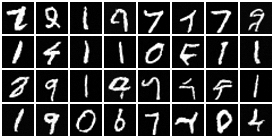

In [ ]:
diffusion = ddpm.SimpleDiffusion(
    num_diffusion_timesteps=TrainingConfig.TIMESTEPS,
    img_shape=TrainingConfig.IMG_SHAPE,
    device=BaseConfig.DEVICE,
)

model = ddpm.UNet(
    input_channels=TrainingConfig.IMG_SHAPE[0],
    output_channels=TrainingConfig.IMG_SHAPE[0],
    base_channels=ModelConfig.BASE_CH,
    base_channels_multiples=ModelConfig.BASE_CH_MULT,
    apply_attention=ModelConfig.APPLY_ATTENTION,
    dropout_rate=ModelConfig.DROPOUT_RATE,
    time_multiple=ModelConfig.TIME_EMB_MULT,
)
model.to(BaseConfig.DEVICE)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters in model: {total_params:,}")
optimizer = torch.optim.AdamW(model.parameters(), lr=TrainingConfig.LR)
dataloader = ddpm.get_dataloader(
    dataset_name=BaseConfig.DATASET,
    batch_size=TrainingConfig.BATCH_SIZE,
    device=BaseConfig.DEVICE,
    pin_memory=True,
    num_workers=TrainingConfig.NUM_WORKERS,
)
scaler = amp.GradScaler(BaseConfig.DEVICE)
total_epochs = TrainingConfig.NUM_EPOCHS + 1
log_dir, checkpoint_dir = ddpm.setup_log_directory(config=BaseConfig())

for epoch in range(1, total_epochs):
    torch.cuda.empty_cache()
    gc.collect()
    ddpm.train_one_epoch(model, diffusion, dataloader, optimizer, scaler, epoch=epoch)
    # Sample images
    if epoch % 1 == 0:
        save_path = os.path.join(log_dir, f"{epoch}.png")

        ddpm.reverse_diffusion(
            model,
            diffusion,
            timesteps=TrainingConfig.TIMESTEPS,
            num_images=32,
            generate_video=False,
            save_path=save_path,
            img_shape=TrainingConfig.IMG_SHAPE,
            device=BaseConfig.DEVICE,
        )

        # clear_output()
        checkpoint_dict = {"opt": optimizer.state_dict(), "scaler": scaler.state_dict(), "model": model.state_dict()}
        torch.save(checkpoint_dict, os.path.join(checkpoint_dir, "ckpt.tar"))
        del checkpoint_dict

## Exercise 3: implement reverse diffusion process (generate new samples)

To generate new images, we will first sample noise ${p_\theta}(x_T)$ and progressively denoise it ${p_\theta}(x_{t-1}|x_t)$ for $t = T,\ldots,1$ to obtain a sequence ${p_\theta}(x_{0:T})$ and use x_0 as our sampled image.

To sample from each ${p_\theta}(x_{t-1}|x_t)$ we use

\begin{align}
p_\theta(x_{t-1} | x_t) &= \mathcal{N}\big(x_{t-1};
\mu_\theta(x_t, t), \beta_t \mathbf{I} \big) \\
\mu_\theta(x_t, t)
    &= \frac{1}{\sqrt{\alpha_t}} \Big(x_t -
    \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\textcolor{lightgreen}{\epsilon_\theta}(x_t, t) \Big)
\end{align}

See https://nn.labml.ai/diffusion/ddpm/evaluate.html for an annotated implementation.

inference_results/MNIST-20250625-182952.mp4


Sampling ::   0%|          | 0/999 [00:00<?, ?it/s]

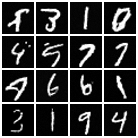

In [12]:
model = ddpm.UNet(
    input_channels=TrainingConfig.IMG_SHAPE[0],
    output_channels=TrainingConfig.IMG_SHAPE[0],
    base_channels=ModelConfig.BASE_CH,
    base_channels_multiples=ModelConfig.BASE_CH_MULT,
    apply_attention=ModelConfig.APPLY_ATTENTION,
    dropout_rate=ModelConfig.DROPOUT_RATE,
    time_multiple=ModelConfig.TIME_EMB_MULT,
)

if os.path.isdir(BaseConfig.root_log_dir):
    folder_numbers = [int(folder.replace("version_", "")) for folder in os.listdir(BaseConfig.root_log_dir)]
    last_version_number = max(folder_numbers)
checkpoint_dir = f"Logs_Checkpoints/{BaseConfig.DATASET}/checkpoints/version_{last_version_number}/"
model.load_state_dict(torch.load(f"{checkpoint_dir}/ckpt.tar", map_location="cpu")["model"])
model.to(BaseConfig.DEVICE)

diffuion = ddpm.SimpleDiffusion(
    num_diffusion_timesteps=TrainingConfig.TIMESTEPS,
    img_shape=TrainingConfig.IMG_SHAPE,
    device=BaseConfig.DEVICE,
)

log_dir = "inference_results"
os.makedirs(log_dir, exist_ok=True)

log_dir = "inference_results"
os.makedirs(log_dir, exist_ok=True)

generate_video = True
ext = ".mp4" if generate_video else ".png"
filename = f"{BaseConfig.DATASET}-{datetime.now().strftime('%Y%m%d-%H%M%S')}{ext}"
save_path = os.path.join(log_dir, filename)
print(save_path)
ddpm.reverse_diffusion(
    model,
    diffusion,
    num_images=16,
    generate_video=generate_video,
    save_path=save_path,
    timesteps=1000,
    img_shape=TrainingConfig.IMG_SHAPE,
    device=BaseConfig.DEVICE,
    nrow=4,
)